# Temporal Convolutional Networks
Are a network architecture described in the paper ‘An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling’
In this notebook we demonstrate an application of this model on the adding problem, in an incremental setting. This is an adaptation of an experiment done in the original paper (The original model and adding experiment can be seen in the authors repository here: https://github.com/locuslab/TCN)

### Reference
Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. ‘An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling’. ArXiv:1803.01271 [Cs], 19 April 2018. http://arxiv.org/abs/1803.01271.


## Implementation
Define the data generator as written in https://github.com/locuslab/TCN/blob/2f8c2b817050206397458dfd1f5a25ce8a32fe65/TCN/adding_problem/utils.py#L6

In [1]:
from sail.models.torch.tcn import TCNRegressor
import numpy as np
import torch
from torch.autograd import Variable

def data_generator(N, seq_length):
    """
    Args:
        seq_length: Length of the adding problem data
        N: # of data in the set
    """
    X_num = torch.rand([N, 1, seq_length])
    X_mask = torch.zeros([N, 1, seq_length])
    Y = torch.zeros([N, 1])
    for i in range(N):
        positions = np.random.choice(seq_length, size=2, replace=False)
        X_mask[i, 0, positions[0]] = 1
        X_mask[i, 0, positions[1]] = 1
        Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
    X = torch.cat((X_num, X_mask), dim=1)
    return Variable(X), Variable(Y)

/Users/mehkj/miniconda3_i386/envs/imla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define parameters. 
Everything is using same default values as original experiment. The only difference is the original experiment is batch learned, where we are incremental.
Original experiment ran for 10 epochs of 50k samples. We run incrementally for 100k samples.

In [2]:
input_channels = 2
n_classes = 1
batch_size = 1
seq_length = 2
#epochs = 10
X_train, Y_train = data_generator(1000, seq_length)
X_test, Y_test = data_generator(100, seq_length)


In [3]:
# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [30]*8 
kernel_size = 7
dropout = 0.0

learning_rate =4e-3

tcn = TCNRegressor(input_channels,n_classes, layers=channel_sizes, ks=kernel_size, conv_dropout=dropout, fc_dropout=dropout, batch_size=batch_size)
tcn.initialize()
from torchinfo import summary
summary(tcn.module_,X_train[:batch_size].shape,col_names=("input_size","output_size","num_params"))

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
_TCN                                     [1, 2, 2]                 [1, 1]                    --
├─_TemporalConvNet: 1-1                  [1, 2, 2]                 [1, 30, 2]                --
│    └─Sequential: 2-1                   [1, 2, 2]                 [1, 30, 2]                --
│    │    └─_TemporalBlock: 3-1          [1, 2, 2]                 [1, 30, 2]                6,930
│    │    └─_TemporalBlock: 3-2          [1, 30, 2]                [1, 30, 2]                12,720
│    │    └─_TemporalBlock: 3-3          [1, 30, 2]                [1, 30, 2]                12,720
│    │    └─_TemporalBlock: 3-4          [1, 30, 2]                [1, 30, 2]                12,720
│    │    └─_TemporalBlock: 3-5          [1, 30, 2]                [1, 30, 2]                12,720
│    │    └─_TemporalBlock: 3-6          [1, 30, 2]                [1, 30, 2]                12,720
│    │    └─

In [4]:
for i in range(0,X_train.size(0), batch_size):
    if i + batch_size > X_train.size(0):
        x, y = X_train[i:], Y_train[i:]
    else:
        x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
    tcn.partial_fit(x, y)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.8995  0.0254
      2        0.7669  0.0181
      3        1.8724  0.0143
      4        0.0890  0.0133
      5        0.1229  0.0138
      6        0.2363  0.0135
      7        0.0216  0.0128
      8        0.5413  0.0129
      9        0.1294  0.0129
     10        0.0637  0.0126
     11        0.5392  0.0129
     12        0.7447  0.0130
     13        0.1814  0.0126
     14        0.0007  0.0126
     15        0.0345  0.0126
     16        0.1226  0.0129
     17        0.0166  0.0130
     18        0.0187  0.0127
     19        0.0282  0.0129
     20        0.1038  0.0129
     21        0.0000  0.0133
     22        0.3901  0.0127
     23        0.4566  0.0132
     24        0.5629  0.0129
     25        0.3761  0.0130
     26        0.5041  0.0127
     27        0.0025  0.0127
     28        0.0684  0.0131
     29        0.1254  0.0132
     30        0.0182  0.0134
     31        0.0027  0.0130
     32   

In [5]:
y_pred = tcn.predict(X_test).flatten().tolist()

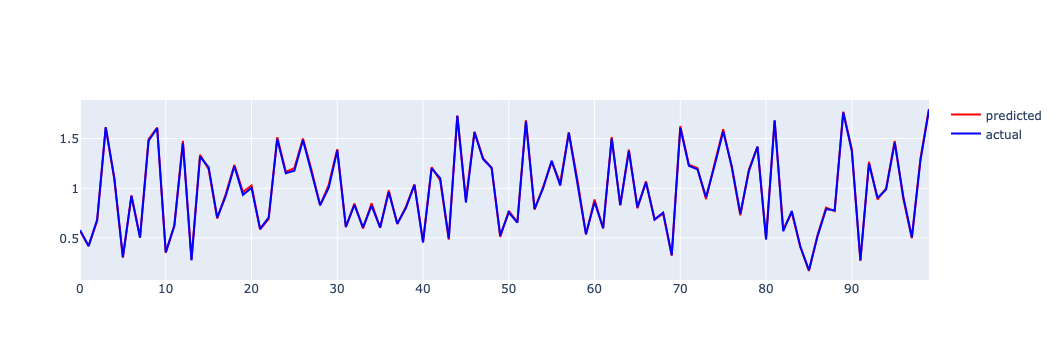

In [6]:

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'vscode'
y_true = Y_test.flatten().tolist()
x = np.arange(len(y_true))
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y_pred, name='predicted',
                         line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=x, y=y_true, name='actual',
                         line=dict(color='blue', width=2)))
fig.show()